In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
import numpy as np
LEARNING_RATE = 0.0001

0.90 - For proving that using pre-trained model works better

In [2]:
# train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm_hive_1_train_copy", 0.30, 16)
train_ds, val_ds, label_names = dataset_tf("./dataset/pitched_transformed_train", 0.50, 16)

Found 560 files belonging to 2 classes.
Using 280 files for training.
Using 280 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (16, 4000)
Example label shape: (16,)


2024-03-26 23:52:31.299371: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-26 23:52:31.299398: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-26 23:52:31.299405: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-26 23:52:31.299440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-26 23:52:31.299458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
for example_wv, example_wv_labels in train_ds.take(1):
  break

In [4]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

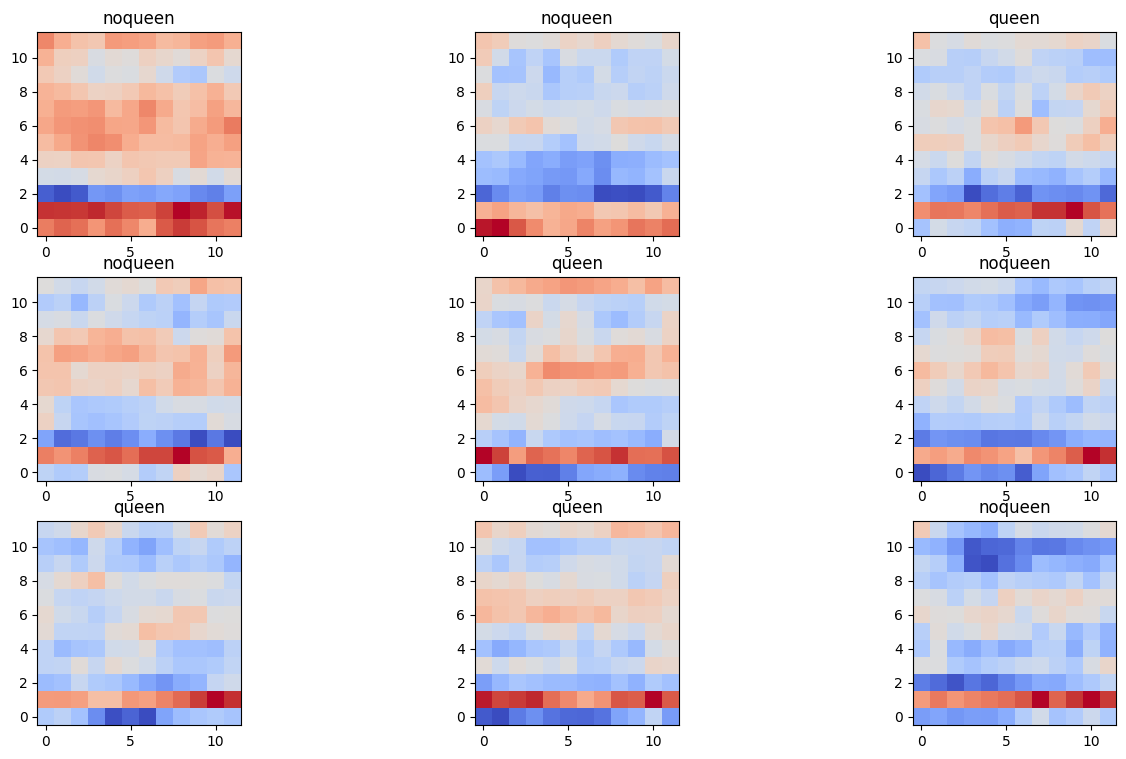

In [5]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [6]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [7]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-26 23:52:32.766989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
 1/18 [>.............................] - ETA: 8s - loss: 0.7062 - accuracy: 0.5625

2024-03-26 23:52:33.354387: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


18/18 [==============================] - 1s 36ms/step - loss: 0.7426 - accuracy: 0.4857 - val_loss: 0.7174 - val_accuracy: 0.5000
Epoch 2/20
18/18 [==============================] - 0s 14ms/step - loss: 0.6210 - accuracy: 0.6643 - val_loss: 0.6610 - val_accuracy: 0.6857
Epoch 3/20
18/18 [==============================] - 0s 17ms/step - loss: 0.5597 - accuracy: 0.7393 - val_loss: 0.6110 - val_accuracy: 0.7036
Epoch 4/20
18/18 [==============================] - 0s 14ms/step - loss: 0.4919 - accuracy: 0.8036 - val_loss: 0.5859 - val_accuracy: 0.6536
Epoch 5/20
18/18 [==============================] - 0s 14ms/step - loss: 0.4191 - accuracy: 0.8429 - val_loss: 0.5426 - val_accuracy: 0.7464
Epoch 6/20
18/18 [==============================] - 0s 14ms/step - loss: 0.3690 - accuracy: 0.8464 - val_loss: 0.5318 - val_accuracy: 0.7214
Epoch 7/20
18/18 [==============================] - 0s 14ms/step - loss: 0.3287 - accuracy: 0.8571 - val_loss: 0.5356 - val_accuracy: 0.7679
Epoch 8/20
18/18 [======

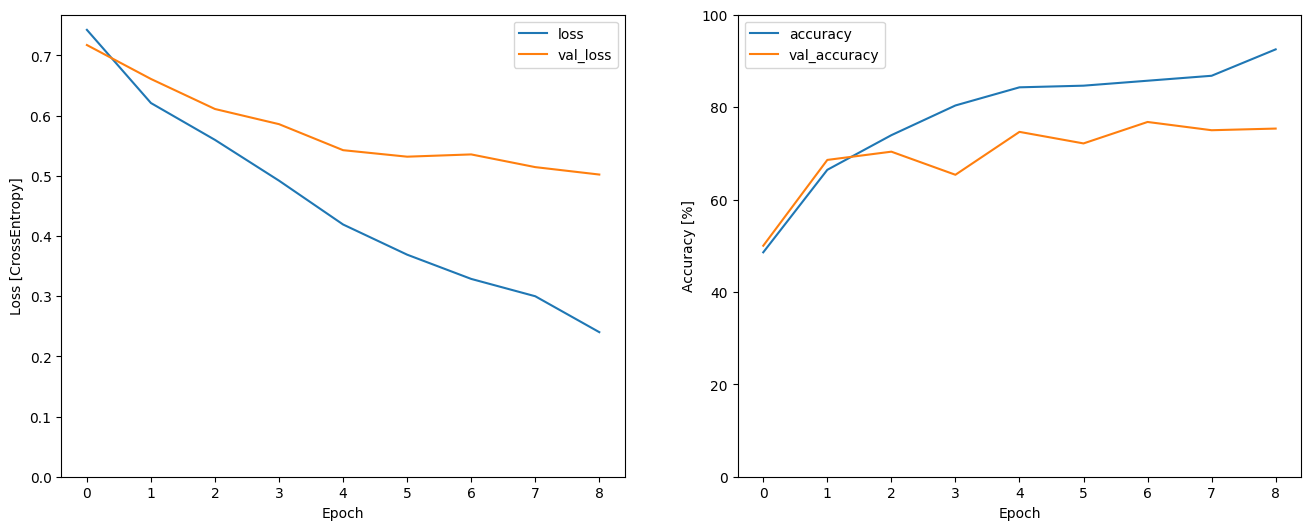

In [8]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/20
18/18 [==============================] - 1s 18ms/step - loss: 0.7203 - accuracy: 0.5000 - val_loss: 0.6886 - val_accuracy: 0.5250
Epoch 2/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6889 - accuracy: 0.5607 - val_loss: 0.6782 - val_accuracy: 0.6036
Epoch 3/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6838 - accuracy: 0.5214 - val_loss: 0.6754 - val_accuracy: 0.5679
Epoch 4/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6765 - accuracy: 0.5857 - val_loss: 0.6702 - val_accuracy: 0.6179
Epoch 5/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6703 - accuracy: 0.6071 - val_loss: 0.6651 - val_accuracy: 0.6536
Epoch 6/20
18/18 [==============================] - 0s 8ms/step - loss: 0.6653 - accuracy: 0.6429 - val_loss: 0.6601 - val_accuracy: 0.6571
Epoch 7/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6598 - accuracy: 0.6357 - val_loss: 0.6561 - val_accuracy: 0.6393
Epoch 8/20
18/18 [=

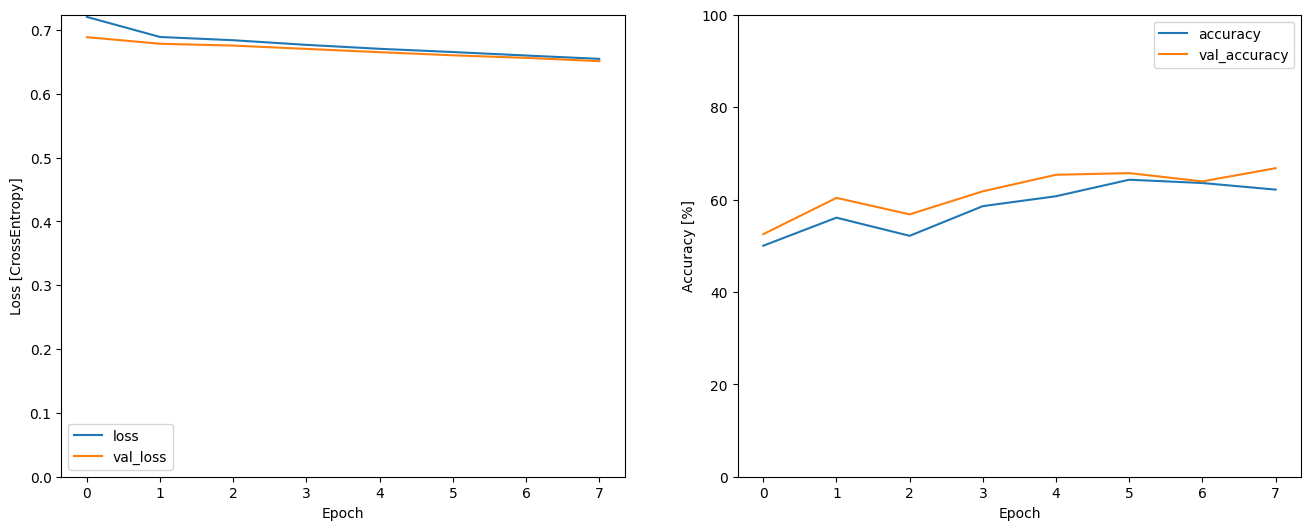

In [9]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


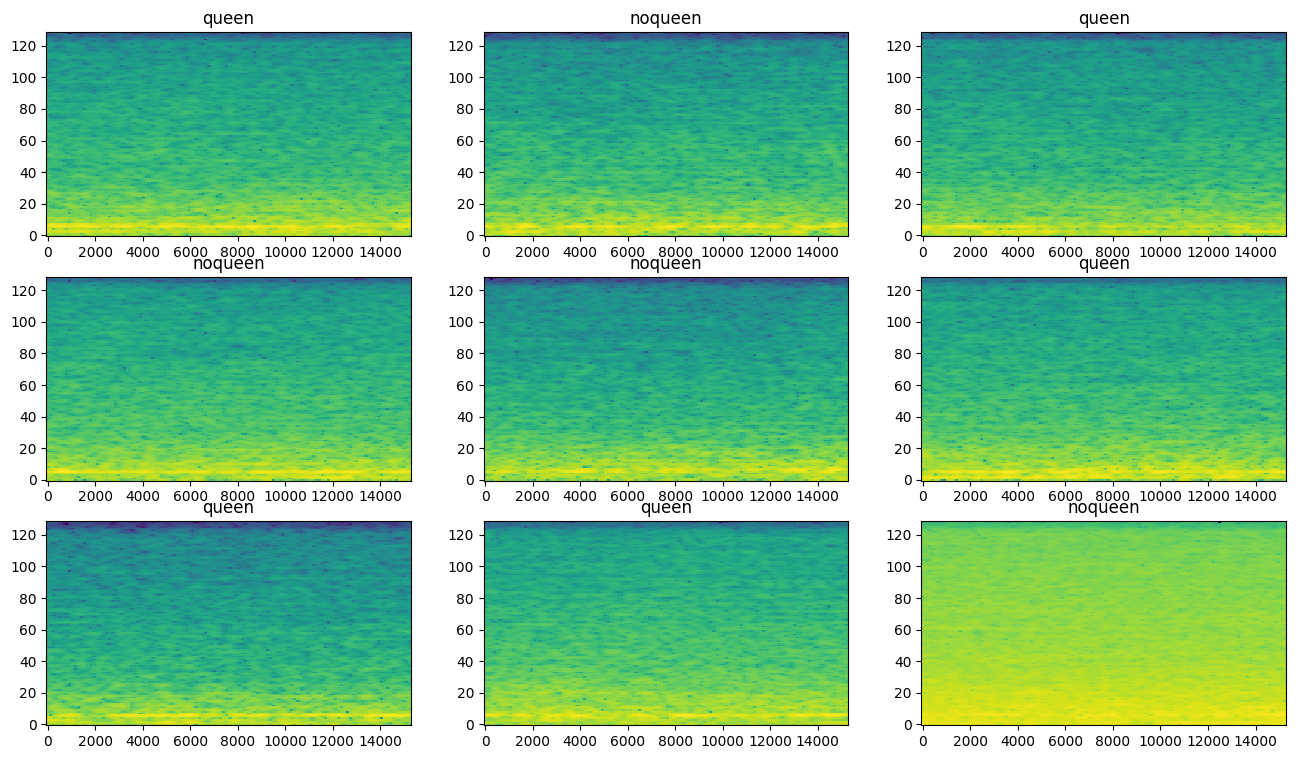

In [10]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [11]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/20
18/18 [==============================] - 1s 30ms/step - loss: 0.7051 - accuracy: 0.5357 - val_loss: 0.6866 - val_accuracy: 0.6036
Epoch 2/20
18/18 [==============================] - 0s 15ms/step - loss: 0.6650 - accuracy: 0.6036 - val_loss: 0.6966 - val_accuracy: 0.5429
Epoch 3/20
18/18 [==============================] - 0s 16ms/step - loss: 0.6459 - accuracy: 0.6071 - val_loss: 0.6914 - val_accuracy: 0.5214
Epoch 4/20
18/18 [==============================] - 0s 16ms/step - loss: 0.6231 - accuracy: 0.6786 - val_loss: 0.6792 - val_accuracy: 0.6000
Epoch 5/20
18/18 [==============================] - 0s 14ms/step - loss: 0.5997 - accuracy: 0.7071 - val_loss: 0.6776 - val_accuracy: 0.5786
Epoch 6/20
18/18 [==============================] - 0s 14ms/step - loss: 0.5934 - accuracy: 0.6964 - val_loss: 0.6856 - val_accuracy: 0.6000


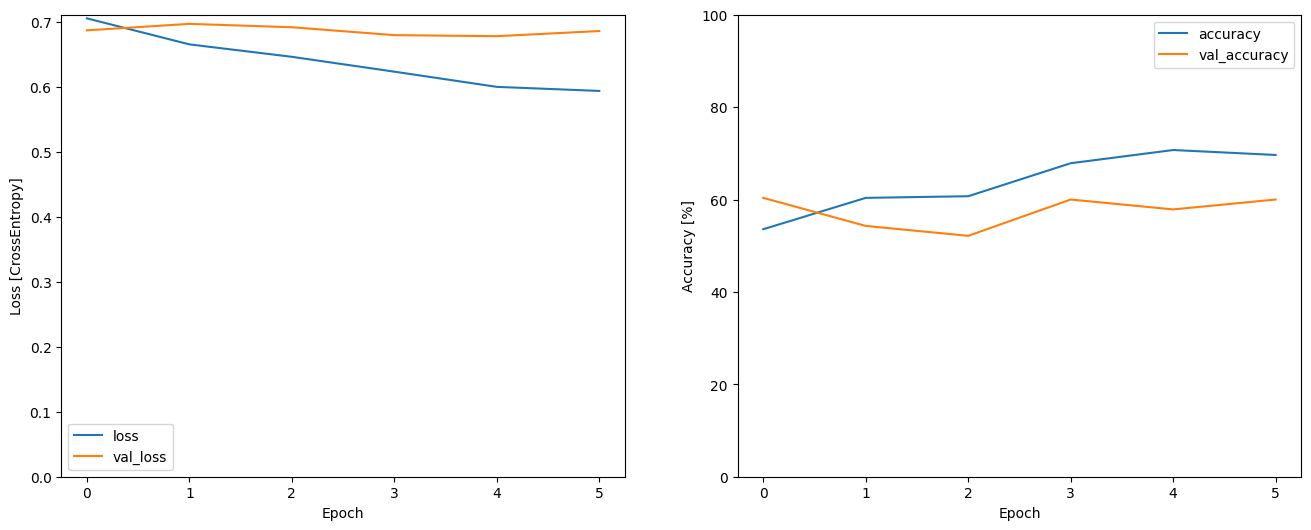

In [12]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/20
18/18 [==============================] - 1s 25ms/step - loss: 0.7188 - accuracy: 0.4929 - val_loss: 0.6897 - val_accuracy: 0.5857
Epoch 2/20
18/18 [==============================] - 0s 16ms/step - loss: 0.6748 - accuracy: 0.5714 - val_loss: 0.6911 - val_accuracy: 0.5179
Epoch 3/20
18/18 [==============================] - 0s 11ms/step - loss: 0.6576 - accuracy: 0.6500 - val_loss: 0.6770 - val_accuracy: 0.5929
Epoch 4/20
18/18 [==============================] - 0s 10ms/step - loss: 0.6427 - accuracy: 0.6679 - val_loss: 0.6829 - val_accuracy: 0.5679
Epoch 5/20
18/18 [==============================] - 0s 10ms/step - loss: 0.6251 - accuracy: 0.6786 - val_loss: 0.6623 - val_accuracy: 0.6179
Epoch 6/20
18/18 [==============================] - 0s 10ms/step - loss: 0.6006 - accuracy: 0.7393 - val_loss: 0.6703 - val_accuracy: 0.6107
Epoch 7/20
18/18 [==============================] - 0s 11ms/step - loss: 0.5737 - accuracy: 0.7607 - val_loss: 0.6694 - val_accuracy: 0.6107


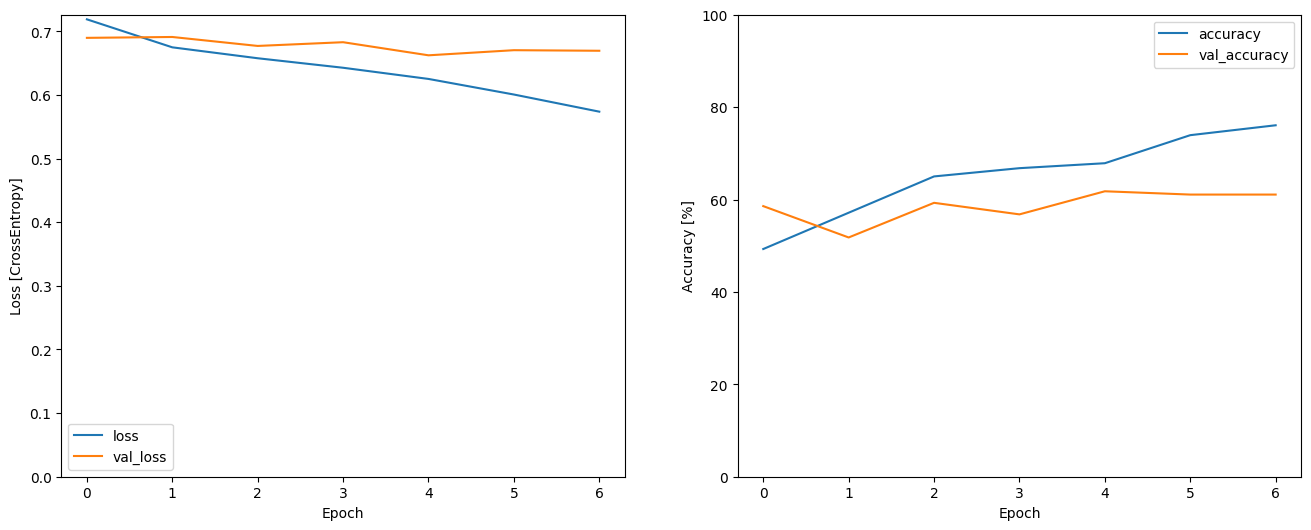

In [13]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [14]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [15]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

18/18 [==============================] - 0s 8ms/step - loss: 0.7842 - accuracy: 0.5750
MFCC Seq: [0.7842406630516052, 0.574999988079071]
18/18 [==============================] - 0s 5ms/step - loss: 1.3274 - accuracy: 0.5036
MFCC Conv: [1.32742440700531, 0.5035714507102966]
18/18 [==============================] - 0s 9ms/step - loss: 5.3877 - accuracy: 0.5000
Spec Seq: [5.387673377990723, 0.5]
18/18 [==============================] - 0s 6ms/step - loss: 13.6877 - accuracy: 0.5000
Spec Conv: [13.687749862670898, 0.5]


### [Reinf] [MFCCs] Sequential model

Epoch 1/20
18/18 [==============================] - 1s 20ms/step - loss: 0.8788 - accuracy: 0.5929 - val_loss: 0.6386 - val_accuracy: 0.6393
Epoch 2/20
18/18 [==============================] - 0s 15ms/step - loss: 0.6679 - accuracy: 0.6357 - val_loss: 0.6240 - val_accuracy: 0.6571
Epoch 3/20
18/18 [==============================] - 0s 15ms/step - loss: 0.5880 - accuracy: 0.6857 - val_loss: 0.5813 - val_accuracy: 0.6857
Epoch 4/20
18/18 [==============================] - 0s 15ms/step - loss: 0.5330 - accuracy: 0.7286 - val_loss: 0.5678 - val_accuracy: 0.7036
Epoch 5/20
18/18 [==============================] - 0s 15ms/step - loss: 0.4943 - accuracy: 0.7643 - val_loss: 0.5609 - val_accuracy: 0.7071
Epoch 6/20
18/18 [==============================] - 0s 16ms/step - loss: 0.4728 - accuracy: 0.7821 - val_loss: 0.5510 - val_accuracy: 0.7214
Epoch 7/20
18/18 [==============================] - 0s 15ms/step - loss: 0.4445 - accuracy: 0.7893 - val_loss: 0.5453 - val_accuracy: 0.7286
Epoch 8/20
18

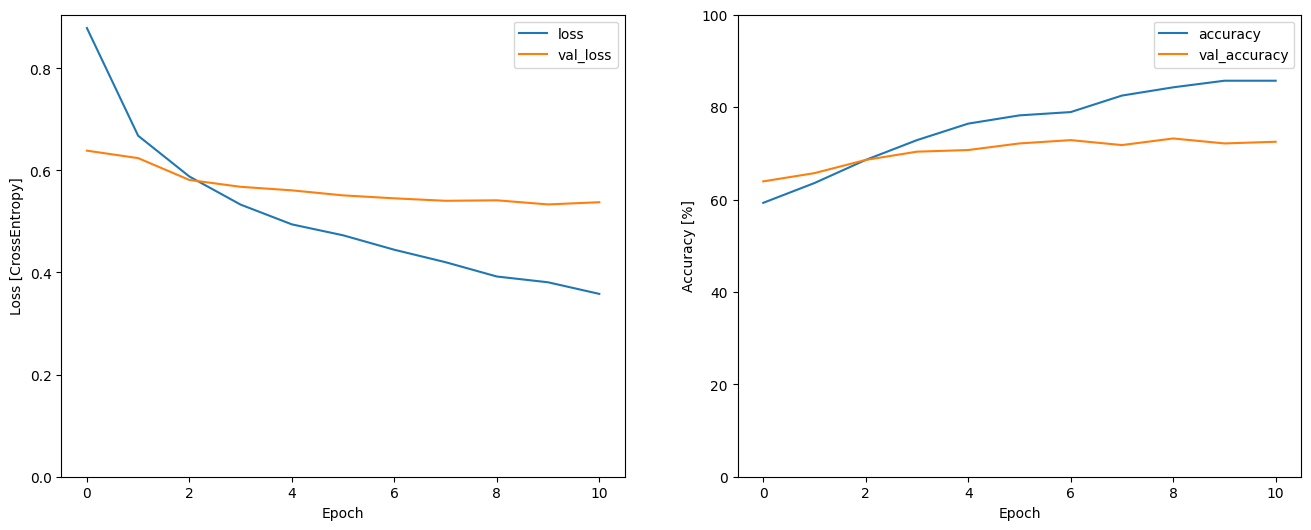

In [16]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/20
18/18 [==============================] - 0s 11ms/step - loss: 0.9403 - accuracy: 0.4679 - val_loss: 0.8121 - val_accuracy: 0.4964
Epoch 2/20
18/18 [==============================] - 0s 10ms/step - loss: 0.7616 - accuracy: 0.4929 - val_loss: 0.7292 - val_accuracy: 0.5321
Epoch 3/20
18/18 [==============================] - 0s 8ms/step - loss: 0.7186 - accuracy: 0.5393 - val_loss: 0.6987 - val_accuracy: 0.5607
Epoch 4/20
18/18 [==============================] - 0s 9ms/step - loss: 0.6874 - accuracy: 0.5714 - val_loss: 0.6864 - val_accuracy: 0.5786
Epoch 5/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6786 - accuracy: 0.5750 - val_loss: 0.6788 - val_accuracy: 0.6143
Epoch 6/20
18/18 [==============================] - 0s 8ms/step - loss: 0.6611 - accuracy: 0.6143 - val_loss: 0.6717 - val_accuracy: 0.5821
Epoch 7/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6570 - accuracy: 0.5893 - val_loss: 0.6599 - val_accuracy: 0.6500
Epoch 8/20
18/18 [

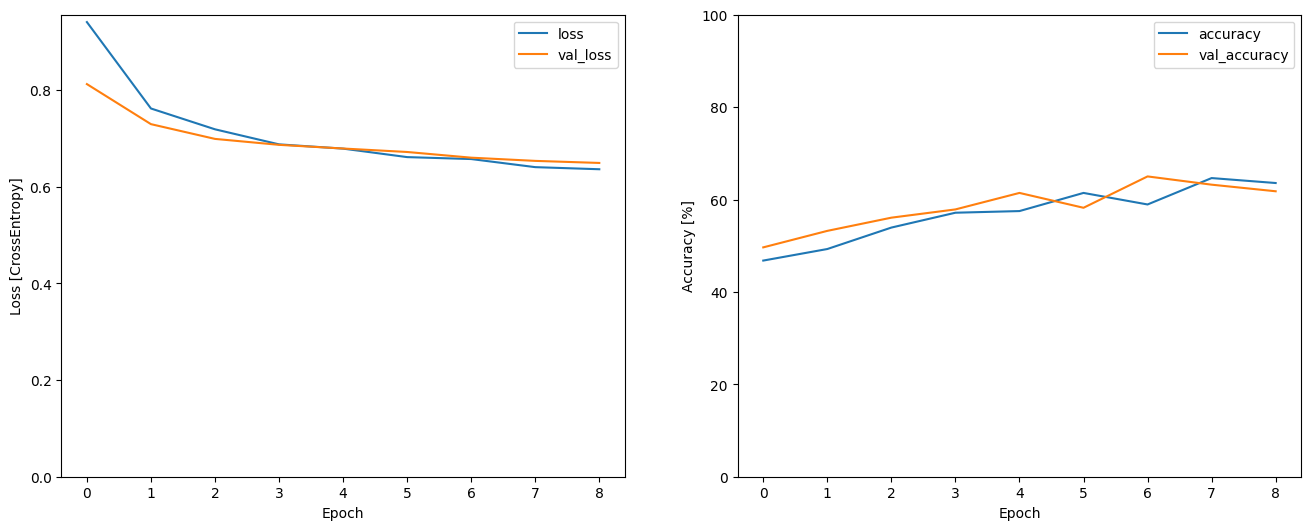

In [17]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/20
18/18 [==============================] - 1s 20ms/step - loss: 2.5259 - accuracy: 0.5071 - val_loss: 1.5322 - val_accuracy: 0.5071
Epoch 2/20
18/18 [==============================] - 0s 17ms/step - loss: 0.9984 - accuracy: 0.6036 - val_loss: 0.7506 - val_accuracy: 0.5929
Epoch 3/20
18/18 [==============================] - 0s 15ms/step - loss: 0.7871 - accuracy: 0.6107 - val_loss: 0.7370 - val_accuracy: 0.6036
Epoch 4/20
18/18 [==============================] - 0s 15ms/step - loss: 0.7028 - accuracy: 0.6429 - val_loss: 0.7087 - val_accuracy: 0.6179
Epoch 5/20
18/18 [==============================] - 0s 16ms/step - loss: 0.6155 - accuracy: 0.6893 - val_loss: 0.7618 - val_accuracy: 0.5786
Epoch 6/20
18/18 [==============================] - 0s 16ms/step - loss: 0.5590 - accuracy: 0.7107 - val_loss: 0.7275 - val_accuracy: 0.5964


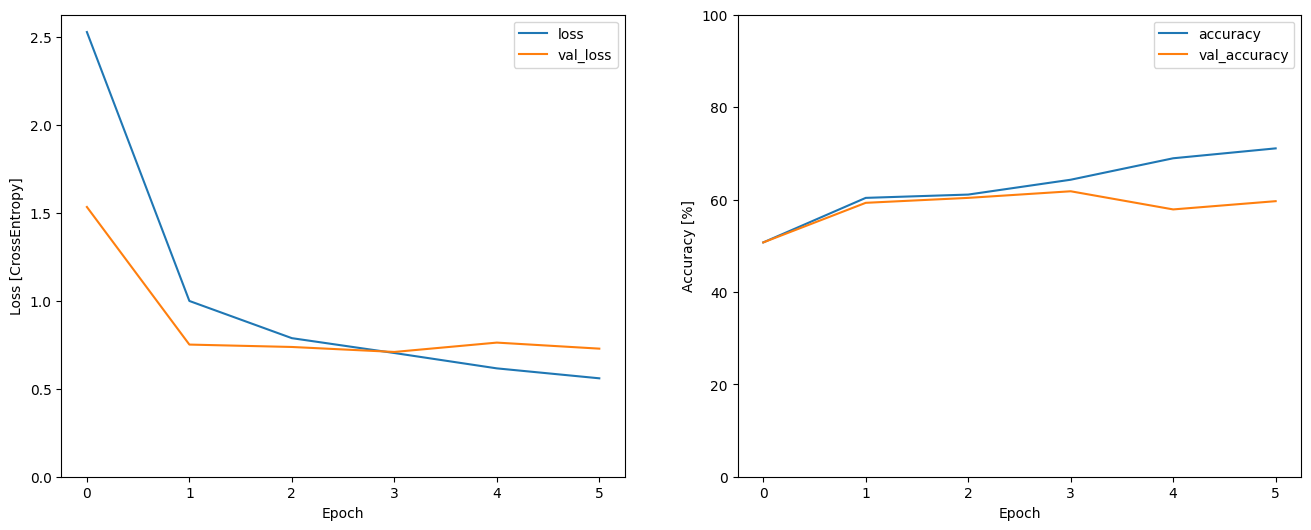

In [18]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/20
18/18 [==============================] - 1s 18ms/step - loss: 6.5486 - accuracy: 0.4714 - val_loss: 5.5903 - val_accuracy: 0.5000
Epoch 2/20
18/18 [==============================] - 0s 13ms/step - loss: 4.6766 - accuracy: 0.4964 - val_loss: 3.5823 - val_accuracy: 0.5071
Epoch 3/20
18/18 [==============================] - 0s 10ms/step - loss: 3.1172 - accuracy: 0.4821 - val_loss: 2.3647 - val_accuracy: 0.5143
Epoch 4/20
18/18 [==============================] - 0s 10ms/step - loss: 2.2347 - accuracy: 0.4643 - val_loss: 1.6446 - val_accuracy: 0.4929
Epoch 5/20
18/18 [==============================] - 0s 8ms/step - loss: 1.7753 - accuracy: 0.4964 - val_loss: 1.3378 - val_accuracy: 0.4786
Epoch 6/20
18/18 [==============================] - 0s 9ms/step - loss: 1.5966 - accuracy: 0.5036 - val_loss: 1.2371 - val_accuracy: 0.5107
Epoch 7/20
18/18 [==============================] - 0s 9ms/step - loss: 1.5377 - accuracy: 0.5179 - val_loss: 1.2085 - val_accuracy: 0.5250
Epoch 8/20
18/18

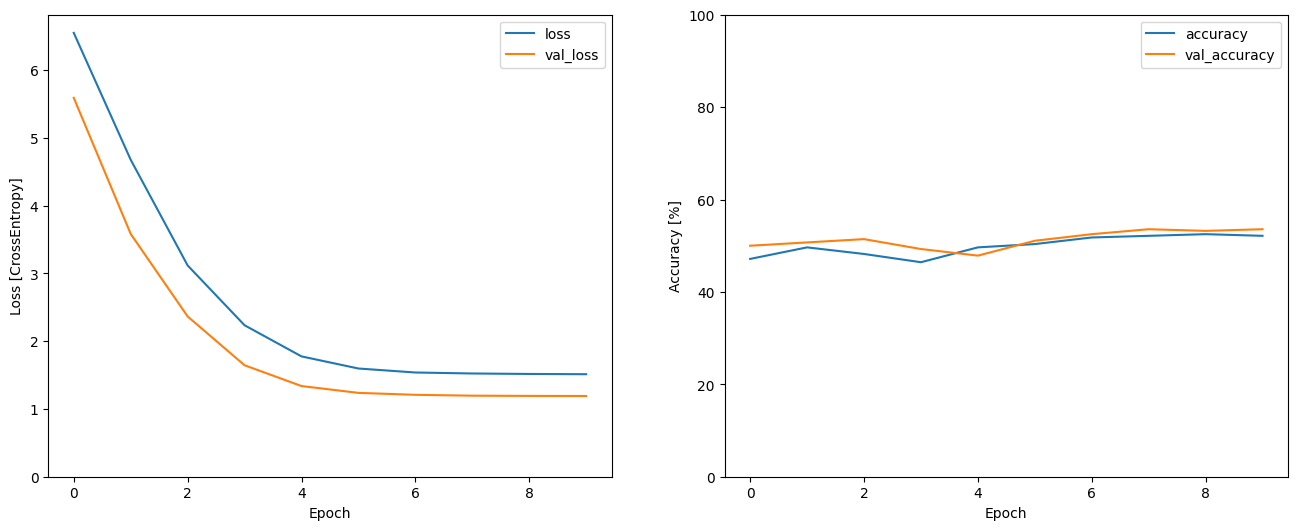

In [19]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [20]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Summary

In [21]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, VLoss: {history.history['val_loss'][-1]:.2f}, VAcc: {history.history['val_accuracy'][-1]:.2f}" )

print("=== RAW ===")
history_to_summary("MFCCs + Seq       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv      ", history_mfcc_conv)
history_to_summary("Spectrogram + Seq ", history_spec_seq)
history_to_summary("Spectrogram + Conv", history_spec_conv)
print("")
print("=== TRAINED ===")
history_to_summary("Tr. MFCCs + Seq       ", trained_history_mfcc_seq)
history_to_summary("Tr. MFCCs + Conv      ", trained_history_mfcc_conv)
history_to_summary("Tr. Spectrogram + Seq ", trained_history_spec_seq)
history_to_summary("Tr. Spectrogram + Conv", trained_history_spec_conv)


=== RAW ===
MFCCs + Seq       :    Loss: 0.24, Acc: 0.93, VLoss: 0.50, VAcc: 0.75
MFCCs + Conv      :    Loss: 0.65, Acc: 0.62, VLoss: 0.65, VAcc: 0.67
Spectrogram + Seq :    Loss: 0.59, Acc: 0.70, VLoss: 0.69, VAcc: 0.60
Spectrogram + Conv:    Loss: 0.57, Acc: 0.76, VLoss: 0.67, VAcc: 0.61

=== TRAINED ===
Tr. MFCCs + Seq       :    Loss: 0.36, Acc: 0.86, VLoss: 0.54, VAcc: 0.73
Tr. MFCCs + Conv      :    Loss: 0.64, Acc: 0.64, VLoss: 0.65, VAcc: 0.62
Tr. Spectrogram + Seq :    Loss: 0.56, Acc: 0.71, VLoss: 0.73, VAcc: 0.60
Tr. Spectrogram + Conv:    Loss: 1.51, Acc: 0.52, VLoss: 1.19, VAcc: 0.54
